In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os, random, shutil
import sklearn
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing import image
from sklearn.metrics import accuracy_score, classification_report
from pathlib import Path
import cv2
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Load Data

In [4]:
dir_path = 'C:/Users/srija/Downloads/chest_xray'
train_dir = dir_path + '/train'
test_dir = dir_path + '/test'

In [5]:
classes = []
for i in os.listdir(train_dir):
  classes.append(i)
classes

['NORMAL', 'PNEUMONIA']

In [6]:
n_train = []
n_test = []
for c in classes:
  train_images = os.listdir(train_dir + '/' + c)
  n_train.append(len(train_images))
  test_images = os.listdir(test_dir + '/' + c)
  n_test.append(len(test_images))

In [7]:
print(n_train)
print(n_test)

[1349, 3883]
[234, 390]


In [8]:
data = pd.DataFrame({'Classes' : classes,
                      'Train' : n_train,
                      'Test' : n_test})
print(data)

     Classes  Train  Test
0     NORMAL   1349   234
1  PNEUMONIA   3883   390


In [11]:
plt.title?

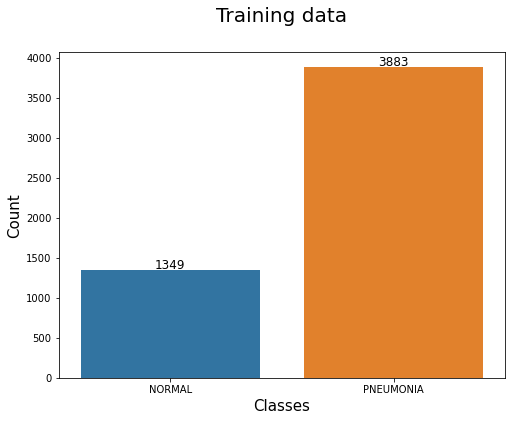

In [25]:
plt.figure(figsize=(8,6))
ax = sns.barplot(data=data, x='Classes', y='Train')
plt.xlabel('Classes', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.title('Training data', fontsize=20, pad=30)
# Add count numbers on top of the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')
plt.show()

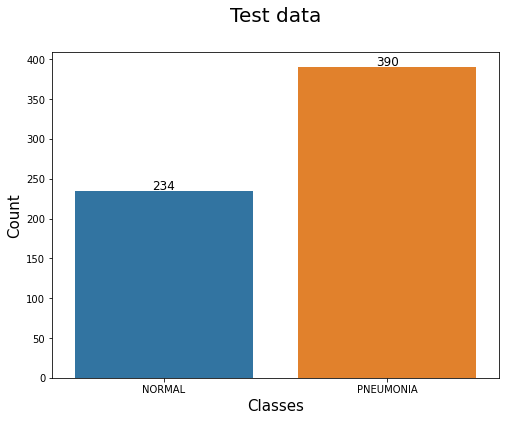

In [30]:
plt.figure(figsize=(8,6))
ax = sns.barplot(data=data, x='Classes', y='Test')
plt.xlabel('Classes', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.title('Test data', fontsize=20, pad=30)
# Add count numbers on top of the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')
plt.show()

In [33]:
train_df = pd.DataFrame({'Path':ptrain,'Class':ctrain})
test_df = pd.DataFrame({'Path':ptest,'Class':ctest})
train_df.head()

,Path,Class
0,C:/Users/srija/Downloads/chest_xray/train/NORM...,NORMAL
1,C:/Users/srija/Downloads/chest_xray/train/NORM...,NORMAL
2,C:/Users/srija/Downloads/chest_xray/train/NORM...,NORMAL
3,C:/Users/srija/Downloads/chest_xray/train/NORM...,NORMAL
4,C:/Users/srija/Downloads/chest_xray/train/NORM...,NORMAL


In [34]:
train_df.to_csv('train_data.csv',index=False)
test_df.to_csv('test_data.csv',index=False)

In [ ]:
img_file, img_class = row['Path'], row['Class']

In [39]:
# Define the paths to your data directories, Replace with the actual path
train_directory = os.path.join(dir_path, 'train')
validation_directory = os.path.join(dir_path, 'validation')

# Define the percentage of data to move to the validation set (e.g., 20%)
validation_split = 0.2

# Create the validation directory if it doesn't exist
os.makedirs(validation_directory, exist_ok=True)

In [40]:
# Iterate through each class (NORMAL and PNEUMONIA)
for class_name in ['NORMAL', 'PNEUMONIA']:
    class_directory = os.path.join(train_directory, class_name)
    validation_class_directory = os.path.join(validation_directory, class_name)

    # Create the validation class directory if it doesn't exist
    os.makedirs(validation_class_directory, exist_ok=True)

    # List all images in the class directory
    images = os.listdir(class_directory)

    # Calculate the number of images to move to the validation set
    num_validation_images = int(len(images) * validation_split)

    # Randomly select images for the validation set
    validation_images = random.sample(images, num_validation_images)

    # Move the selected images to the validation class directory
    for image in validation_images:
        source_path = os.path.join(class_directory, image)
        destination_path = os.path.join(validation_class_directory, image)
        shutil.move(source_path, destination_path)

print('Validation set created successfully.')

Validation set created successfully.


In [ ]:
# Define data generators with augmentation for training, validation, and testing
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,      # Rescale pixel values to [0, 1]
    rotation_range=5,      # Random rotation
    width_shift_range=0.1,  # Random horizontal shift
    height_shift_range=0.1, # Random vertical shift
    zoom_range=0.1,         # Random zoom
    horizontal_flip=True,   # Random horizontal flip
    fill_mode='nearest'     # Fill mode for pixel filling
)

validation_datagen = ImageDataGenerator(rescale=1.0/255.0)  # Only rescale for validation

test_datagen = ImageDataGenerator(rescale=1.0/255.0)        # Only rescale for testing

In [52]:
# Create data generators for training, validation, and testing
batch_size = 32
train_generator = train_datagen.flow_from_directory(
    os.path.join(dir_path, 'train'),
    target_size=(150, 150),  # Specify your desired image size
    batch_size=batch_size,
    class_mode='binary'      # Change to 'categorical' if you have multiple classes
)

validation_generator = validation_datagen.flow_from_directory(
    os.path.join(dir_path, 'validation'),
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='binary'      # Change to 'categorical' if you have multiple classes
)

test_generator = test_datagen.flow_from_directory(
    os.path.join(dir_path, 'test'),
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='binary'      # Change to 'categorical' if you have multiple classes
)

Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [57]:
# Create CNN Model from scratch

In [53]:
model = Sequential()
model.add(Conv2D(32,(3,3),input_shape=(150, 150, 3), padding='same'))
model.add(Conv2D(32,(3,3), padding='same'))
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(32,(3,3), padding='same'))
model.add(Conv2D(32,(3,3), padding='same'))
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(64,(3,3), padding='same'))
model.add(Conv2D(64,(3,3), padding='same'))
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(512))
model.add(Activation("relu"))
model.add(BatchNormalization())

model.add(Dense(64))
model.add(Activation("relu"))
model.add(Dropout(0.5))

model.add(Dense(1))
model.add(Activation("sigmoid"))

In [58]:
#model.summary()

In [55]:
model.compile(loss= "binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [56]:
history = model.fit_generator(train_generator, epochs=3 ,validation_data=validation_generator)

Epoch 1/3
131/131 [==============================] - 378s 3s/step - loss: 0.3472 - accuracy: 0.8646 - val_loss: 2.6282 - val_accuracy: 0.7426
Epoch 2/3
131/131 [==============================] - 283s 2s/step - loss: 0.2308 - accuracy: 0.9143 - val_loss: 1.2740 - val_accuracy: 0.7426
Epoch 3/3
131/131 [==============================] - 275s 2s/step - loss: 0.2022 - accuracy: 0.9255 - val_loss: 0.2773 - val_accuracy: 0.8813


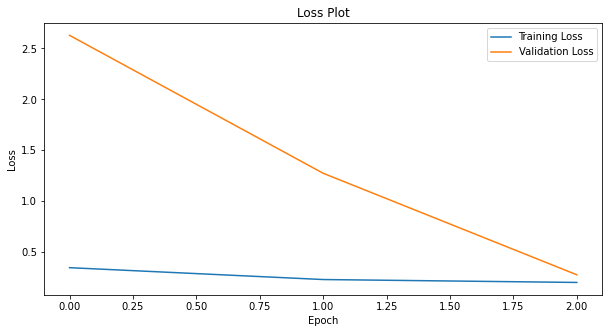

In [59]:
# Plot loss during training
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.legend()
plt.show()

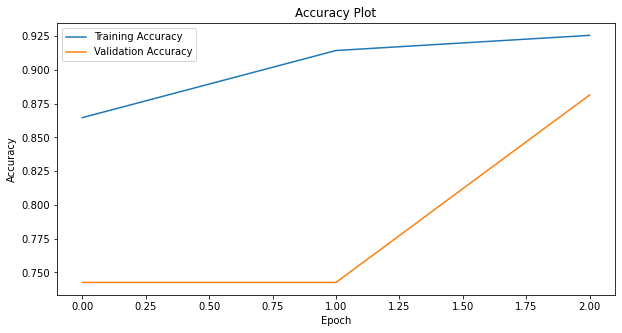

In [60]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Plot')
plt.legend()
plt.show()

In [61]:
test_accuracy = model.evaluate_generator(test_generator)

In [62]:
print('The accuracy on test set :',test_accuracy[1]*100 )

The accuracy on test set : 68.58974099159241


In [63]:
from sklearn.metrics import confusion_matrix

# Calculate precision, recall, and F1 score
test_predictions = model.predict(test_generator)
test_predictions = (test_predictions > 0.5).astype(int)
print("Classification Report:")
print(classification_report(test_generator.classes, test_predictions))

20/20 [==============================] - 16s 803ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.37      0.16      0.22       234
           1       0.62      0.83      0.71       390

    accuracy                           0.58       624
   macro avg       0.49      0.50      0.47       624
weighted avg       0.53      0.58      0.53       624



In [64]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(test_generator.classes, test_predictions)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[ 38 196]
 [ 66 324]]


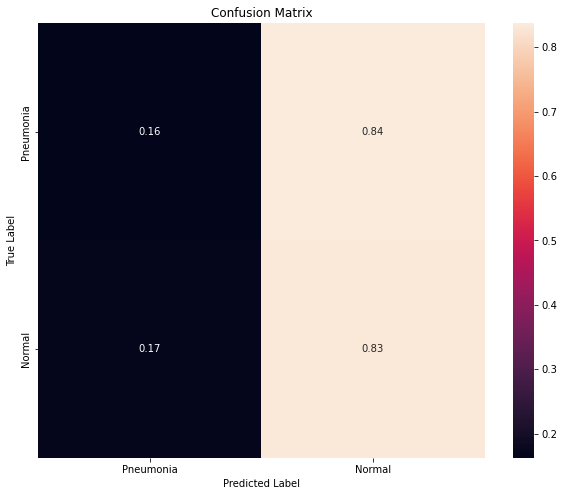

In [65]:
row_sums = conf_matrix.sum(axis=1, keepdims=True)
norm_conf_matrix = conf_matrix / row_sums

# Display colored confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(norm_conf_matrix, annot=True, xticklabels=['Pneumonia','Normal'], yticklabels=['Pneumonia','Normal'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Transfer Learning using Inception V3

In [66]:
from keras.applications import InceptionV3, VGG16
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout

# Load the InceptionV3 model without the top (fully connected) layers
base_model = InceptionV3(input_shape = (150, 150, 3), weights='imagenet', include_top=False)

#base_model = VGG16(include_top=False, weights='imagenet', input_shape=(32, 32, 3))

87910968/87910968 [==============================] - 7s 0us/step


In [67]:
# Add your own top layers for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = True

# Compile the model with binary cross-entropy loss
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#model.summary()

In [68]:
# Train the model
history = model.fit(train_generator, epochs=5, validation_data=validation_generator)

Epoch 1/5
131/131 [==============================] - 1061s 8s/step - loss: 0.2496 - accuracy: 0.9186 - val_loss: 21937.3066 - val_accuracy: 0.7426
Epoch 2/5
131/131 [==============================] - 945s 7s/step - loss: 0.1883 - accuracy: 0.9455 - val_loss: 0.9055 - val_accuracy: 0.6995
Epoch 3/5
131/131 [==============================] - 1014s 8s/step - loss: 0.1025 - accuracy: 0.9639 - val_loss: 1.8632 - val_accuracy: 0.7024
Epoch 4/5
131/131 [==============================] - 1130s 9s/step - loss: 0.0782 - accuracy: 0.9718 - val_loss: 0.1158 - val_accuracy: 0.9656
Epoch 5/5
131/131 [==============================] - 857s 7s/step - loss: 0.0849 - accuracy: 0.9733 - val_loss: 0.4256 - val_accuracy: 0.9043


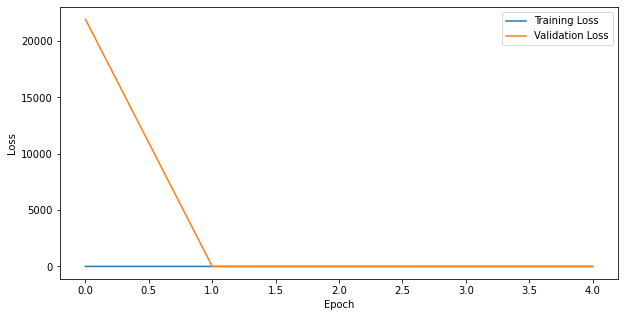

In [69]:
# Plot loss during training
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.title('Loss Plot')
plt.legend()
plt.show()

In [70]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Calculate precision, recall, and F1 score
test_predictions = model.predict(test_generator)
test_predictions = (test_predictions > 0.5).astype(int)
print("Classification Report:")
print(classification_report(test_generator.classes, test_predictions))

20/20 [==============================] - 29s 1s/step - loss: 0.3706 - accuracy: 0.8782
Test Loss: 0.3706294000148773, Test Accuracy: 0.8782051205635071
20/20 [==============================] - 31s 1s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.35      0.32      0.33       234
           1       0.61      0.63      0.62       390

    accuracy                           0.52       624
   macro avg       0.48      0.48      0.48       624
weighted avg       0.51      0.52      0.51       624



In [71]:
# Calculate confusion matrix

conf_matrix = confusion_matrix(test_generator.classes, test_predictions)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[ 76 158]
 [144 246]]


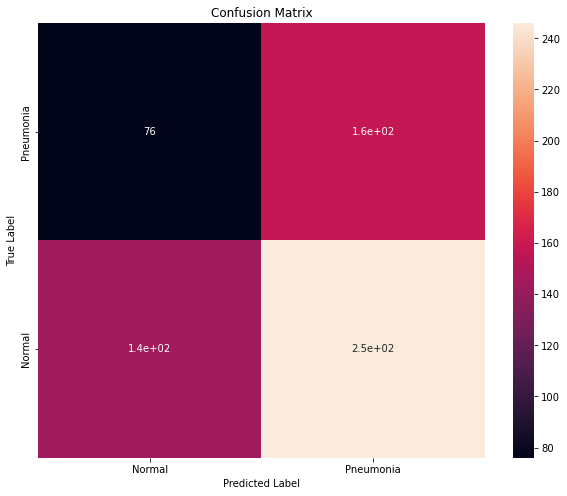

In [74]:
row_sums = conf_matrix.sum(axis=1, keepdims=True)
norm_conf_matrix = conf_matrix / row_sums

# Display colored confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, xticklabels=['Normal', 'Pneumonia'], yticklabels=['Pneumonia','Normal'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Save the trained model
model.save('classifier_model.h5')